In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

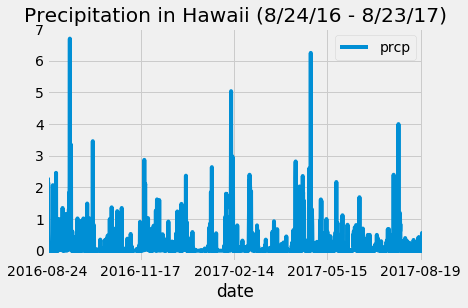

In [16]:
# Calculate the date 1 year ago from the last data point in the database
latest_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent = dt.datetime.strptime(latest_data[0], '%Y-%m-%d')
year_before = dt.date(most_recent.year -1, most_recent.month, most_recent.day)
# Perform a query to retrieve the data and precipitation scores
prcp_data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_before).order_by(Measurement.date).all())
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.set_index('date')
prcp_df = prcp_df.dropna()
# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation in Hawaii (8/24/16 - 8/23/17)");

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f"Number of stations: {station_count}")

Number of stations: 9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_activity = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
stn_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = stn_activity[0][0]
hi_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active).order_by(Measurement.tobs.desc()).first()
lo_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active).order_by(Measurement.tobs.asc()).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active)

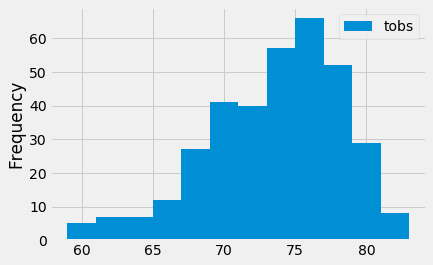

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_active = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > year_before).filter(Measurement.station == most_active).order_by(Measurement.date).all())
year_active

temp_df = pd.DataFrame(year_active)
temp_df = temp_df.set_index('date')
temp_df

temp_df.plot(kind='hist', bins=12);

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-05-19', '2016-05-25'))

[(67.0, 75.62222222222222, 79.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-05-19', '2016-05-25'))
print(calc_temps('2015-05-19', '2015-05-25'))

[(67.0, 75.62222222222222, 79.0)]
[(64.0, 72.10416666666667, 77.0)]


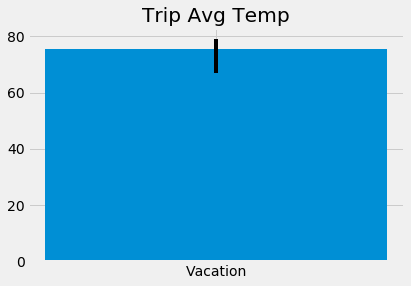

In [24]:
# Plot the results from your previous query as a bar chart. 
arrival = '2016-05-19'
departure = '2016-05-25'
forecast = calc_temps(arrival, departure)
forecast

vacation_lo = forecast[0][0]
vacation_avg = forecast[0][1]
vacation_hi = forecast[0][2]

min_error = vacation_avg - vacation_lo
max_error = vacation_hi - vacation_avg
errors = np.array([[min_error], [max_error]])
plt.bar("Vacation", vacation_avg, width=4, yerr=errors);
plt.title("Trip Avg Temp");

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
each_stn = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])
stn_prcp = (session.query(*each_stn).filter(Station.station == Measurement.station).filter(Measurement.date >= arrival).filter(Measurement.date <= departure).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all())
stn_prcp_df = pd.DataFrame(np.array(stn_prcp))
stn_prcp_df = stn_prcp_df.rename(columns={0: "Station", 1: "Location", 2: "Precipitation", 3: "Latitude", 4: "Longitude", 5: "Elevation"})

stn_prcp_df

,Station,Location,Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.71,21.3331,-157.803,152.4
1,USC00519281,"WAIHEE 837.5, HI US",0.56,21.4517,-157.849,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.28,21.4234,-157.802,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.28,21.5213,-157.837,7
4,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.2716,-157.817,3
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0,21.3356,-157.711,19.5
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
